In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
del raw_df['target_sum']
raw_df.head(2)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 33.7+ MB


In [4]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


In [5]:
raw_df['channel_type'] = raw_df['channel_type'].fillna('unknown')

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe

Вычислим количество транзакций по дням недели и часам

In [6]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') ) 
    tmp_df = dataset.groupby(['cl_id','day_of_transaction'])['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day_of_transaction'].unique()]
    tmp_df.rename(columns={old_col: 'day_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df
    
def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
    return dataset.groupby(['cl_id','hour_of_transaction'])['hour_of_transaction'].size().unstack().fillna(0).reset_index()

tr_by_day_count = transaction_by_day_count(raw_df)
tr_by_hour_count = transaction_by_hour_count(raw_df)
tr_by_hour_count.head(3)

hour_of_transaction,cl_id,00,01,02,03,04,05,06,07,08,...,14,15,16,17,18,19,20,21,22,23
0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,5,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0


In [7]:
#создадим датафрейм для агрегаций:
df = tr_by_day_count.merge(tr_by_hour_count,on='cl_id',how='left')
df.head()

,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6,00,01,...,14,15,16,17,18,19,20,21,22,23
0,0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7.0,20.0,20.0,16.0,16.0,10.0,15.0,101.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,5,15.0,19.0,19.0,15.0,25.0,24.0,25.0,124.0,0.0,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
3,9,5.0,8.0,7.0,5.0,6.0,4.0,4.0,7.0,1.0,...,0.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0
4,10,74.0,35.0,62.0,68.0,65.0,57.0,102.0,299.0,3.0,...,6.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


Вычислим количество и долю транзакций по каждой из trx_category

In [8]:
def aggregations(dataset,column):
    tmp_df = pd.get_dummies(raw_df, columns = [column]).groupby('cl_id').sum()
    tmp_df = tmp_df.iloc[:,4:]
    tmp_df2 = tmp_df.div(tmp_df.sum(axis=1), axis=0)
    
    cols = tmp_df.columns
    for col1 in cols:
        for col2 in cols:
            if col1 != col2:
                try:
                    tmp_df['{}_{}'.format(col1,col2)] = tmp_df['{}'.format(col1)]/tmp_df['{}'.format(col2)]
                except ZeroDivisionError:
                    tmp_df['{}_{}'.format(col1,col2)] = np.nan
    
    tmp_df = tmp_df.merge(tmp_df2,on='cl_id',how='left', suffixes = ('', '_Share'))
    
    return tmp_df

In [9]:
aggr = aggregations(raw_df,'trx_category')

In [10]:
df = df.merge(aggr,on='cl_id',how='left')

Определим популярные категории для валют и кодов MCC

In [11]:
def topcategories(df, columnname, limit = 1000):
    vc = pd.concat([df[columnname], df[columnname]], sort=False).value_counts()
    common = vc > limit
    common = set(common.index[common].values)
    print("Занесено", sum(vc <= limit), columnname, "категорий в other;", end=" ")
    
    df.loc[df[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("Теперь количество категорий равно:", df[columnname].nunique())
    print(df[columnname].value_counts())

In [12]:
topcategories(raw_df,'currency',1000)
topcategories(raw_df,'MCC',5000)

Занесено 55 currency категорий в other; Теперь количество категорий равно: 5
810      477644
978        5536
other      4851
840        1921
933         561
Name: currency, dtype: int64
Занесено 314 MCC категорий в other; Теперь количество категорий равно: 31
5411     121640
other     66070
6011      54382
5814      41351
5812      30027
5499      27237
5541      19816
5912      18728
5999      13073
6012      10056
5921       8578
5331       7641
4121       6266
5211       6262
4829       6205
5691       5161
5261       4803
4111       4362
5977       4300
5200       3460
5732       3271
5311       3258
5533       2946
5651       2915
4812       2857
5641       2710
8099       2674
5722       2667
5661       2601
8999       2599
5941       2597
Name: MCC, dtype: int64


Создадим новые признаки на основе категорий валют: sum, mean, std, min, max платежей каждого клиента.

In [13]:
curr_df = raw_df[['cl_id','amount','currency']]
curr_df = pd.get_dummies(curr_df, columns = ['currency'])
for col in curr_df.columns[2:]:
    curr_df[col] = curr_df[col]*curr_df['amount']
del curr_df['amount']

curr_df_sum = curr_df.groupby('cl_id').sum()
curr_df_mean = curr_df.groupby('cl_id').mean()
curr_df_std = curr_df.groupby('cl_id').std()
curr_df_max = curr_df.groupby('cl_id').max()
curr_df_min = curr_df.groupby('cl_id').min()

curr_df = pd.merge(curr_df_sum,curr_df_mean, on='cl_id', how='left', suffixes = ('_sum','_mean'))
curr_df = pd.merge(curr_df,curr_df_std, on='cl_id', how='left', suffixes = ('','_std'))
curr_df = pd.merge(curr_df,curr_df_max, on='cl_id', how='left', suffixes = ('','_max'))
curr_df = pd.merge(curr_df,curr_df_min, on='cl_id', how='left', suffixes = ('','_min'))

In [14]:
df = df.merge(curr_df,on='cl_id',how='left')

Вычислим продолжительность использования карты

In [15]:
dt_dict = {'JAN':'01',
    'FEB':'02',
    'MAR':'03',
    'APR':'04',
    'MAY':'05', 
    'JUN':'06',  
    'JUL':'07',
    'AUG':'08',
    'SEP':'09',
    'OCT':'10',
    'NOV':'11', 
    'DEC':'12'}

def dt_preprocess(t):
    day = t[0:2]
    month = dt_dict[t[2:5]]
    year = t[5:7]
    hour = t[8:10]
    minute = t[11:13]
    second = t[14:]
    return '20'+str(year)+'-'+str(month)+'-'+str(day)

raw_df['time'] = raw_df['TRDATETIME'].apply(lambda x: dt_preprocess(x))
raw_df['time'] = pd.to_datetime(raw_df['time'])

def dt_preprocess(t):
    day = t[0:2]
    month = dt_dict[t[2:5]]
    year = t[5:7]
    hour = t[8:10]
    minute = t[11:13]
    second = t[14:]
    return '20'+str(year)+'-'+str(month)+'-'+str(day)+' '+str(hour)+":"+str(minute)+':'+str(second)

raw_df['TRDATETIME'] = raw_df['TRDATETIME'].apply(lambda x: dt_preprocess(x))
raw_df['TRDATETIME'] = pd.to_datetime(raw_df['TRDATETIME'])

raw_df['max_date'] = raw_df['cl_id'].map(raw_df.groupby('cl_id')['TRDATETIME'].max())
raw_df['min_date'] = raw_df['cl_id'].map(raw_df.groupby('cl_id')['TRDATETIME'].min())
raw_df['duration_of_use'] = (raw_df['max_date'] - raw_df['min_date']).dt.days

In [16]:
dur = raw_df[['cl_id','duration_of_use']].drop_duplicates(keep='first').reset_index(drop=True)
df['duration_of_use'] = dur['duration_of_use']

Вернём таргет в наш датасет

In [17]:
tar = raw_df[['cl_id','target_flag']].drop_duplicates(keep='first').reset_index(drop=True)
df['target_flag'] = tar['target_flag']

In [19]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [20]:
y = df['target_flag'].copy()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
data_train, data_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [22]:
x_train = data_train[df.columns[:-1]]
y_train = data_train['target_flag']
x_test = data_test[df.columns[:-1]]
y_test = data_test['target_flag']

In [23]:
xgb = xgboost.XGBClassifier(max_depth=4, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 4)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.9287
Test:  0.8608


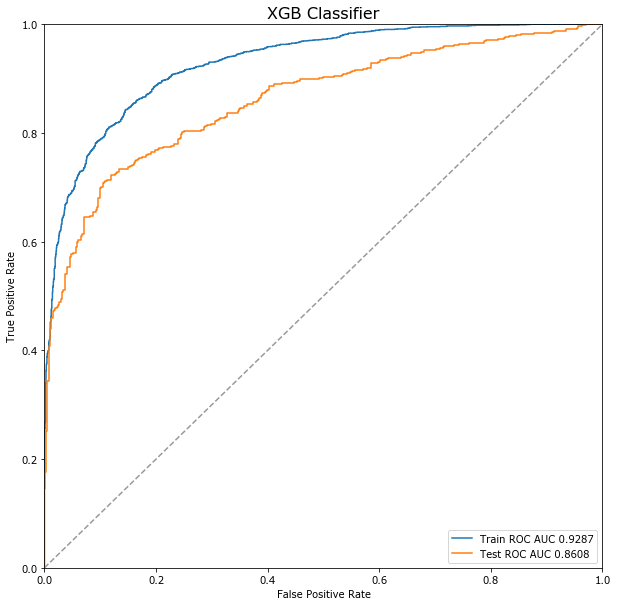

In [24]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

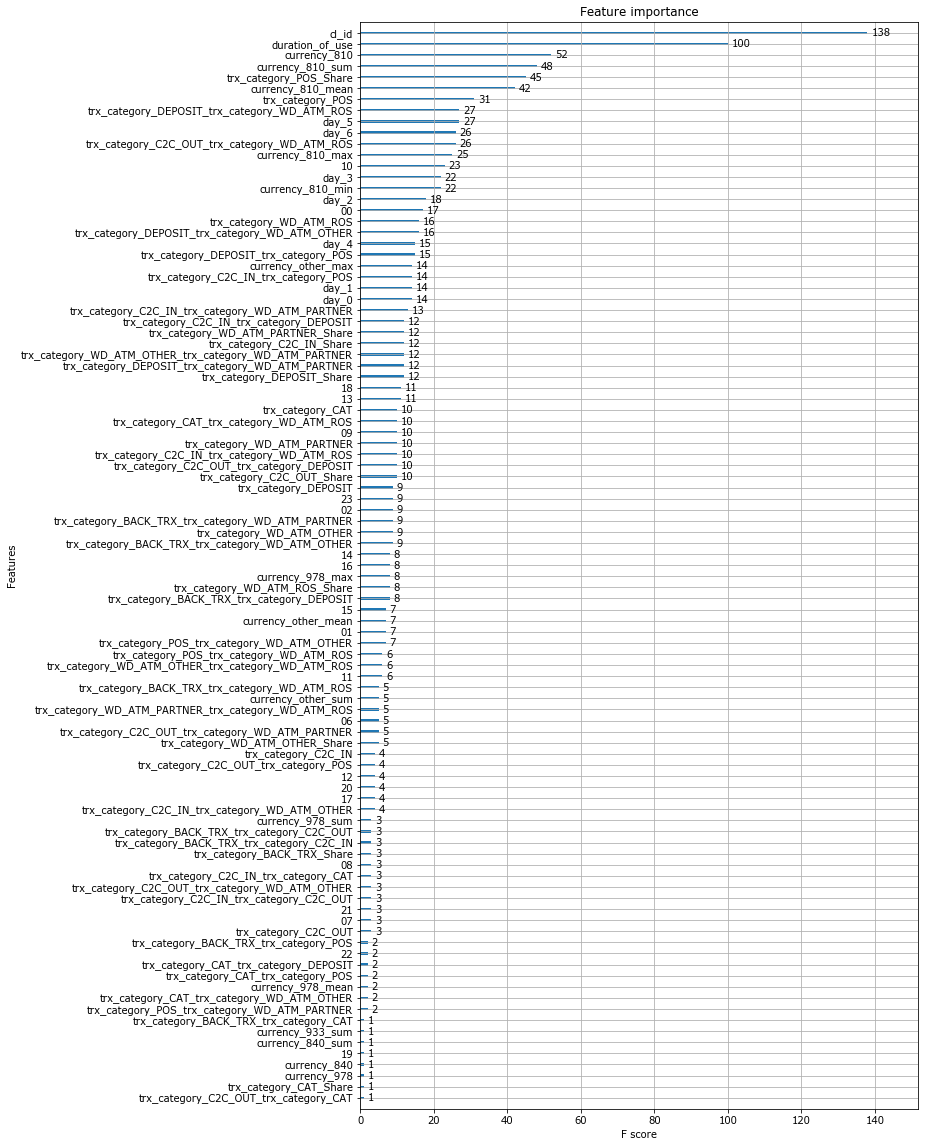

In [25]:
matplotlib.rcParams['figure.figsize'] = (10, 20)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')

**Как видно из таблицы важности признаков больше всего информации содержит фича 'cl_id', что нередко бывает в соревнованиях анализа данных.
Следующим по важности признаком является продолжительность использования данного банковского продукта. Фичи на основе транзакций через POS-терминалы и транзакций в рублях также содержат важную информацию. Более глубокий фиче-инжиниринг может дать новые признаки для чуть более точной модели.**